In [ ]:
%%capture
#%%script false
!pip install shap==0.23.0
!pip install xgboost==0.82
!pip install catboost
#!pip install tensorboardcolab
#!pip install plotly_express
!pip install seaborn==0.9.0
!pip install pandas==0.24.2
!pip install numpy==1.16.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import itertools
from tqdm import tqdm_notebook as tqdm

from sklearn.externals import joblib

# Use this instead of sklearn-pandas
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

CITY, Locality can we extract additional info from them.    

Metro, Non metro,   

Rating per user


In [ ]:
import requests
from bs4 import BeautifulSoup

import re

def extract_pincode(address) :
    url = "https://www.getpincode.info/" + str(address)
    page = requests.get(url)
    
    if page.status_code == 404 :
        out = "skipped"
    else :    
        soup = BeautifulSoup(page.text, 'html.parser')
        out = re.findall("\d{6}", str(soup.find_all('meta',  attrs={'name': 'Keywords'})))[0]
    return out

In [ ]:
# CITY, Locality, Rating, Votes have missing values.
train_data_og = pd.read_csv("drive/My Drive/PyColab Work/MealPrice/train.csv", encoding = "ISO-8859-1")
sub_data_og = pd.read_csv("drive/My Drive/PyColab Work/MealPrice/test.csv", encoding = "ISO-8859-1")

#Verified in both train and sub, only votes is left after split
def clean_data(dataset):
    dataset["RESTAURANT_ID"] = dataset["RESTAURANT_ID"].astype("str")
    dataset["VOTES"] = pd.to_numeric(dataset.VOTES.str.split(" ").str[0])
    
    dataset["LOCALITY"] = np.where(dataset["LOCALITY"].isnull(), "missing", dataset["LOCALITY"])
    dataset["CITY"] = np.where(dataset["CITY"].isnull(), "missing", dataset["CITY"])
    
    dataset["Address"] = dataset["LOCALITY"] + "-" + dataset["CITY"]
    dataset["Address"] = dataset["Address"].str.replace(" ", "-")
    #dataset["pincode"] = dataset["Address"].apply(extract_pincode)
    
    
    #Use list replace instead 
    dataset["RATING"] = np.where(dataset["RATING"] == "-", 0, dataset["RATING"])
    dataset["RATING"] = np.where(dataset["RATING"] == "NEW", 0, dataset["RATING"])
    dataset["RATING"] = dataset["RATING"].astype(float)
    
    #dataset["closed"] = np.where(dataset["TIME"].str.contains("Mon-Sun"), "Never", "someday" )
    
    #For time, if there are multiple entries such as Mon-Fri and Sat-Sun, we can add some varaible?
    
    #pd.isnull(train_data["CUISINES"].str.split(",").str[8]).value_counts()
    #train_data["A"], train_data["B"], train_data["C"], train_data["D"], train_data["E"], train_data["F"], train_data["G"], train_data["H"] =  train_data["CUISINES"].str.split(",").str
    dataset["NoofCuisines"] = dataset["CUISINES"].str.count(",") + 1
    
    return dataset


train_data = clean_data(train_data_og)
sub_data = clean_data(sub_data_og)

# For Mean Encoding (ME) on Title there are 11 entries which get NA.
# Find neareast Title from train_data and replace in sub_data
# Perform this action before mean encoding.
sub_data["TITLE"] = np.where(sub_data["TITLE"] == "CLUB,CASUAL DINING", "CASUAL DINING,CLUB", sub_data["TITLE"])
sub_data["TITLE"] = np.where(sub_data["TITLE"] == "BAKERY,CASUAL DINING", "CASUAL DINING,BAKERY", sub_data["TITLE"])
sub_data["TITLE"] = np.where(sub_data["TITLE"] == "CLUB,FINE DINING", "CASUAL DINING,BAKERY", sub_data["TITLE"])
sub_data["TITLE"] = np.where(sub_data["TITLE"] == "FINE DINING,MICROBREWERY", "CASUAL DINING,MICROBREWERY", sub_data["TITLE"])
sub_data["TITLE"] = np.where(sub_data["TITLE"] == "IRANI CAFE,BAKERY", "CASUAL DINING,IRANI CAFE", sub_data["TITLE"])
sub_data["TITLE"] = np.where(sub_data["TITLE"] == "FOOD TRUCK,DESSERT PARLOR", "FOOD TRUCK", sub_data["TITLE"])
sub_data["TITLE"] = np.where(sub_data["TITLE"] == "PUB,FINE DINING", "CASUAL DINING,PUB", sub_data["TITLE"])
sub_data["TITLE"] = np.where(sub_data["TITLE"] == "QUICK BITES,MEAT SHOP", "MEAT SHOP,QUICK BITES", sub_data["TITLE"])
sub_data["TITLE"] = np.where(sub_data["TITLE"] == "CAFE,FOOD COURT", "FOOD COURT", sub_data["TITLE"])
sub_data["TITLE"] = np.where(sub_data["TITLE"] == "BHOJANALYA", "FOOD COURT", sub_data["TITLE"])

# means = train_data.groupby('TITLE')['COST'].mean()

# train_data["TITLE"] = train_data["TITLE"].map(means) / train_data["NoofCuisines"]
# sub_data["TITLE"] = sub_data["TITLE"].map(means) / train_data["NoofCuisines"]

# means = train_data.groupby('Address')['COST'].mean()

# train_data["Address"] = train_data["Address"].map(means) / train_data["NoofCuisines"]
# sub_data["Address"] = sub_data["Address"].map(means) / train_data["NoofCuisines"]

# # TRY MEAN ENCODING ON CUSINES and then combined on CUSINES and TITLE
# trainCuisines = list( itertools.chain.from_iterable( train_data.CUISINES.str.split(",").tolist() ) )

# for i in tqdm(range(0, len(trainCuisines))):
#     train_data[trainCuisines[i]] = np.where(train_data["CUISINES"].str.contains(trainCuisines[i]), 1,0)
#     means = train_data.groupby(trainCuisines[i])['COST'].mean()
#     train_data[trainCuisines[i]] = train_data[trainCuisines[i]].map(means) / train_data["NoofCuisines"]
    
#     sub_data[trainCuisines[i]] = np.where(sub_data["CUISINES"].str.contains(trainCuisines[i]), 1,0)
#     sub_data[trainCuisines[i]] = sub_data[trainCuisines[i]].map(means) / train_data["NoofCuisines"]

train_data.head(10).T

In [ ]:
# Mean Encoding

means = train_data.groupby('TITLE')['COST'].mean()

train_data["TITLE"] = train_data["TITLE"].map(means) / train_data["NoofCuisines"]
sub_data["TITLE"] = sub_data["TITLE"].map(means) / train_data["NoofCuisines"]

means = train_data.groupby('Address')['COST'].mean()

train_data["Address"] = train_data["Address"].map(means) / train_data["NoofCuisines"]
sub_data["Address"] = sub_data["Address"].map(means) / train_data["NoofCuisines"]

# TRY MEAN ENCODING ON CUSINES and then combined on CUSINES and TITLE
trainCuisines = list( itertools.chain.from_iterable( train_data.CUISINES.str.split(",").tolist() ) )

for i in tqdm(range(0, len(trainCuisines))):
    train_data[trainCuisines[i]] = np.where(train_data["CUISINES"].str.contains(trainCuisines[i]), 1,0)
    means = train_data.groupby(trainCuisines[i])['COST'].mean()
    train_data[trainCuisines[i]] = train_data[trainCuisines[i]].map(means) / train_data["NoofCuisines"]
    
    sub_data[trainCuisines[i]] = np.where(sub_data["CUISINES"].str.contains(trainCuisines[i]), 1,0)
    sub_data[trainCuisines[i]] = sub_data[trainCuisines[i]].map(means) / train_data["NoofCuisines"]

In [ ]:
train_data["RATING"] = train_data["RATING"].fillna(train_data["RATING"].mean())
sub_data["RATING"] = sub_data["RATING"].fillna(train_data["RATING"].mean())

train_data["VOTES"] = train_data["VOTES"].fillna(train_data["VOTES"].mean())
sub_data["VOTES"] = sub_data["VOTES"].fillna(train_data["VOTES"].mean())


65 x 6 x 2 - beer  
110 x 2 - food  
***
260 pint of beer

Are prices capped?

In [ ]:
# We foud this on Zomato - https://www.zomato.com/bangalore/bulls-n-bears-bar-trade-xchange-koramangala-5th-block-bangalore
# 18841054
train_data_og[(train_data_og["LOCALITY"] == "Koramangala 5th Block") & (train_data_og["TITLE"] == "PUB,BAR")]

#https://www.getpincode.info/

In [ ]:
train_data.groupby(trainCuisines[0])['COST'].mean()

Malwani
0    654.926090
1    733.018868
Name: COST, dtype: float64

In [ ]:
train_data.isnull().any()

## EDA

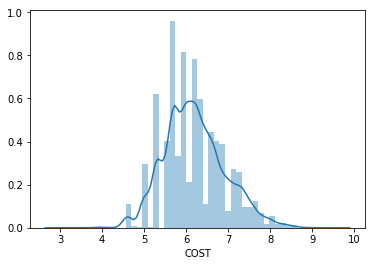

In [ ]:
sns.distplot(np.log(train_data["COST"]))

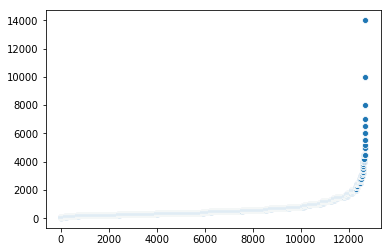

In [ ]:
sns.scatterplot(np.arange(0, len(train_data), 1), np.sort(train_data["COST"]))

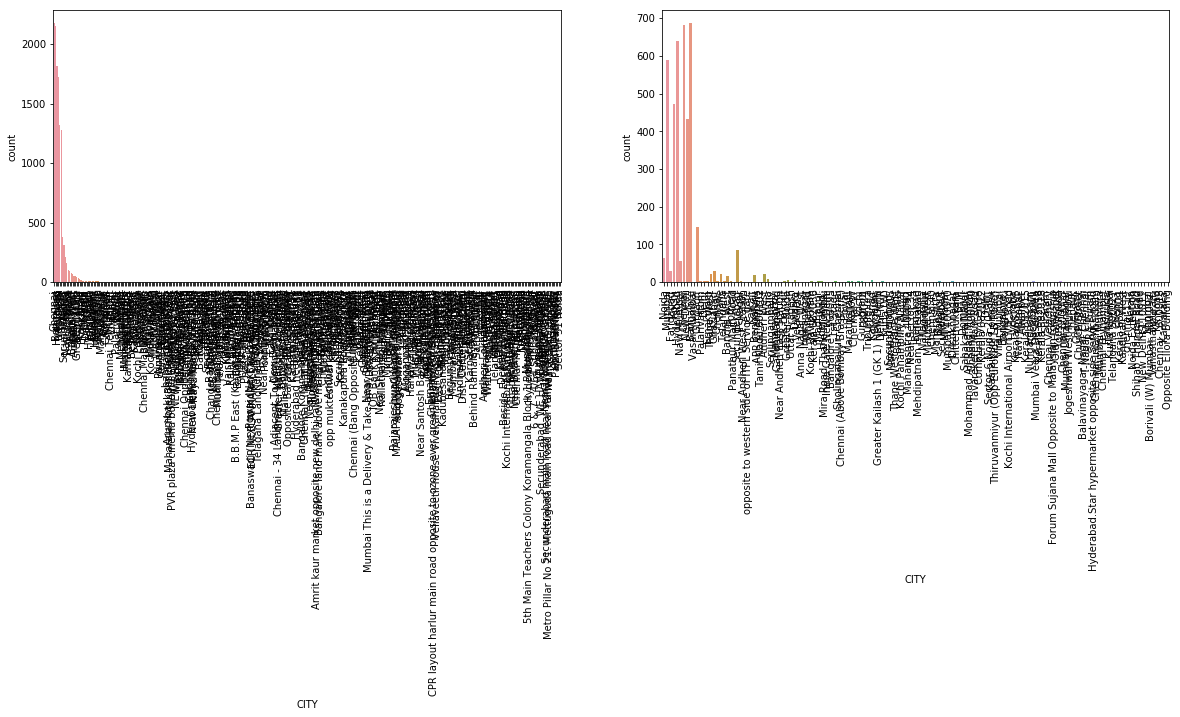

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
sns.countplot(train_data.CITY, order = train_data.CITY.value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(sub_data.CITY, order = train_data.CITY.value_counts().index)
plt.xticks(rotation = 90)
plt.show()

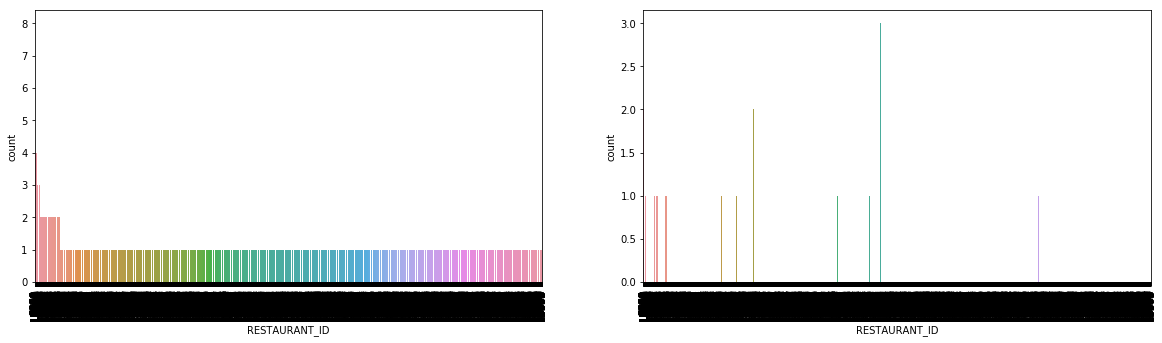

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
sns.countplot(train_data.RESTAURANT_ID, order = train_data.RESTAURANT_ID.value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(sub_data.RESTAURANT_ID, order = train_data.RESTAURANT_ID.value_counts().index)
plt.xticks(rotation = 90)
plt.show()

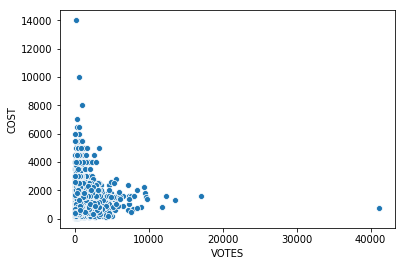

In [ ]:
sns.scatterplot("VOTES", "COST", data = train_data)

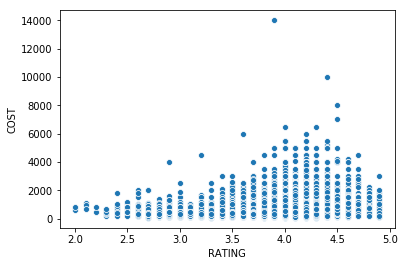

In [ ]:
#train_data[train_data["RATING"] > 0]
sns.scatterplot("RATING", "COST", data = train_data[train_data["RATING"] > 0])

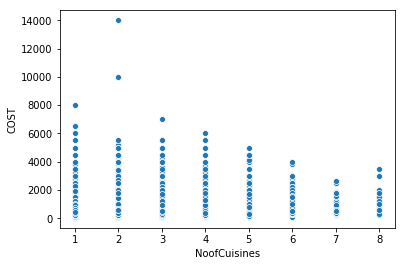

In [ ]:
sns.scatterplot("NoofCuisines", "COST", data = train_data)

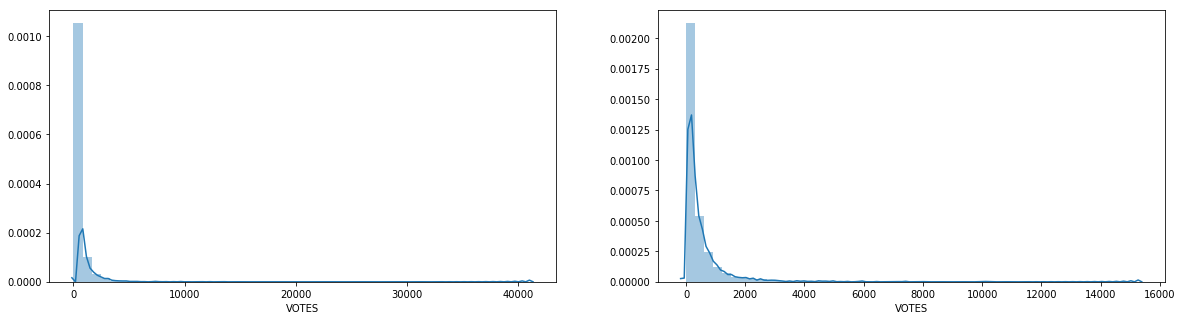

In [ ]:
plt.figure(figsize = (20, 5))
plt.subplot(1,2,1)
sns.distplot(train_data[~train_data["VOTES"].isna()].VOTES)
plt.subplot(1,2,2)
sns.distplot(sub_data[~sub_data["VOTES"].isna()].VOTES)
plt.show()

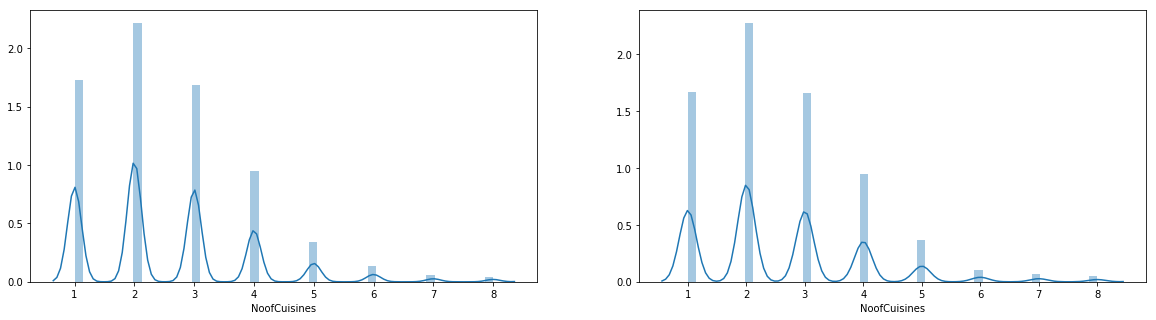

In [ ]:
plt.figure(figsize = (20, 5))
plt.subplot(1,2,1)
sns.distplot(train_data[~train_data["NoofCuisines"].isna()].NoofCuisines)
plt.subplot(1,2,2)
sns.distplot(sub_data[~sub_data["NoofCuisines"].isna()].NoofCuisines)
plt.show()

## Analysis

## Prepare Data

In [ ]:
#CITY LOCALITY HAVE MSSING VALUES
X = train_data.drop(["RESTAURANT_ID", "CITY", "LOCALITY" ,"CUISINES", "LOCALITY", "COST", "TIME"], axis = 1)
y = np.log(train_data.COST)

# Comment this line for catboost
X = pd.get_dummies(X)
X_sub = pd.get_dummies(sub_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["NoofCuisines"])


In [ ]:
X_train.head()

In [ ]:
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test)) #158
print(X_sub.shape, "predict")

(9517, 225) 9517
(3173, 225) 3173


## Model

Leaderboard - 84%

In [ ]:
sub_model = xgb.XGBRegressor(learning_rate=0.1, n_estimators = 25972)
sub_model.fit(X, y, eval_metric = "rmse", verbose = 1000)

In [ ]:
pd.DataFrame({ "ID": sub_data["ID"], "Score": sub_model.predict(X_sub) }).to_csv(index = False)

### XGBOOST

#### XGBOOST

In [ ]:
# X = pd.get_dummies(X)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["NoofCuisines"])

In [ ]:
# VOTES have missing values
xgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators = 100000)
xgb_model.fit(X_train, y_train, eval_metric = "mse", eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 1000, early_stopping_rounds=100)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:5.6869	validation_1-rmse:5.68884
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1000]	validation_0-rmse:0.338548	validation_1-rmse:0.345648
[2000]	validation_0-rmse:0.330621	validation_1-rmse:0.342434
[3000]	validation_0-rmse:0.325341	validation_1-rmse:0.340495
[4000]	validation_0-rmse:0.321315	validation_1-rmse:0.339861
Stopping. Best iteration:
[4610]	validation_0-rmse:0.318866	validation_1-rmse:0.339576



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [ ]:
np.sqrt(cross_val_score(xgb_model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 12, n_jobs = 4))

In [ ]:
cross_validate(xgb_model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10)

In [ ]:
1 - np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))

0.6581142532661755

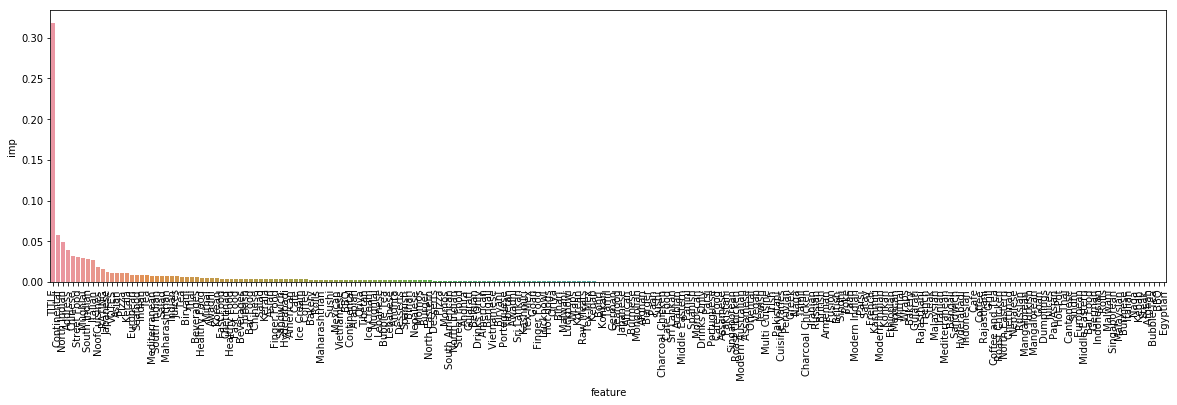

In [ ]:
#%%script false #use shap instead
plt.figure(figsize = (20, 5))
sns.barplot("feature", "imp", data = pd.DataFrame( {'feature' : X_train.columns, 'imp' : xgb_model.feature_importances_ }).sort_values("imp", ascending = False) )
plt.xticks(rotation = 90)
plt.show()
#pd.DataFrame( {'feature' : X_train.columns, 'imp' : xgb_model.feature_importances_ }).sort_values("imp", ascending = False)

#### SHAP

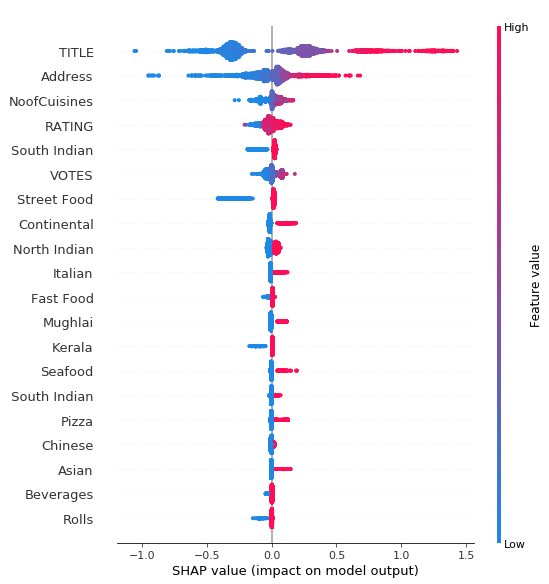

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train.iloc[0:5000,:])
shap.summary_plot(shap_values, X_train.iloc[0:5000,:])

#### Hyperprameter Tuning

In [ ]:
cv= RepeatedKFold(2, 2)
xgb_engine = xgb.XGBRegressor() #n_estimator not used
xgb_params = {'booster' : ['gbtree'],
              'max_depth' : [3, 4], 
              'gamma' : [0], 
              'learning_rate' : [0.3], 
              "n_estimators" : [100000], 
              'min_child_weight' : [5, 10], 
              'subsample' : [1], 
              'colsample_bytree' : [0.7, 1], 
              'colsample_bylevel' : [1], 
              'colsample_bynode' : [1], 
              'reg_lambda' : [0], 
              'reg_alpha' : [0]}

xgb_grid = GridSearchCV(xgb_engine, xgb_params, cv = cv, verbose = 0, return_train_score  = True)
xgb_grid.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=10, verbose = 1000)

#joblib.dump(xgb_grid, "F:/Vasim/Python Stuff/Flight/gridxgboost.sav")

#print( np.sqrt( -cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv = cv, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, xgb_grid.predict(X_test)) ) )

[0]	validation_0-rmse:4.03995
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[525]	validation_0-rmse:0.309877

[0]	validation_0-rmse:4.04138
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[704]	validation_0-rmse:0.308089

[0]	validation_0-rmse:4.04005
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[633]	validation_0-rmse:0.308597

[0]	validation_0-rmse:4.04172
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[600]	validation_0-rmse:0.308471

[0]	validation_0-rmse:4.03995
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[690]	validation_0-rmse:0.309044

[0]	validation_0-rmse:4.04138
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[428]	validation_0-rmse:0.315342

[0]	validation_0-rmse:4.04005
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[820]	validation_0-rmse:0.307517

[0]	validation_0-rmse:4.04172
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[662]	validation_0-rmse:0.311324

[0]	validation_0-rmse:4.03916
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[660]	validation_0-rmse:0.296745

[0]	validation_0-rmse:4.04028
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[679]	validation_0-rmse:0.293566

[0]	validation_0-rmse:4.03798
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[563]	validation_0-rmse:0.297646

[0]	validation_0-rmse:4.04043
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[653]	validation_0-rmse:0.29444

[0]	validation_0-rmse:4.03923
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[539]	validation_0-rmse:0.301758

[0]	validation_0-rmse:4.04032
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[406]	validation_0-rmse:0.303741

[0]	validation_0-rmse:4.03782
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[312]	validation_0-rmse:0.311168

[0]	validation_0-rmse:4.04043
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[616]	validation_0-rmse:0.298966

[0]	validation_0-rmse:4.03136
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[630]	validation_0-rmse:0.306609

[0]	validation_0-rmse:4.03331
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[796]	validation_0-rmse:0.304064

[0]	validation_0-rmse:4.03165
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[768]	validation_0-rmse:0.305456

[0]	validation_0-rmse:4.03341
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[542]	validation_0-rmse:0.308605

[0]	validation_0-rmse:4.03136
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[389]	validation_0-rmse:0.315021

[0]	validation_0-rmse:4.03331
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[741]	validation_0-rmse:0.30868

[0]	validation_0-rmse:4.03165
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[812]	validation_0-rmse:0.306452

[0]	validation_0-rmse:4.03341
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[427]	validation_0-rmse:0.314996

[0]	validation_0-rmse:4.0298
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[631]	validation_0-rmse:0.293787

[0]	validation_0-rmse:4.03177
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[658]	validation_0-rmse:0.293981

[0]	validation_0-rmse:4.03104
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[583]	validation_0-rmse:0.292913

[0]	validation_0-rmse:4.03207
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[607]	validation_0-rmse:0.294166

[0]	validation_0-rmse:4.03017
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[349]	validation_0-rmse:0.303789

[0]	validation_0-rmse:4.03177
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[422]	validation_0-rmse:0.301158

[0]	validation_0-rmse:4.03104
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[581]	validation_0-rmse:0.298204

[0]	validation_0-rmse:4.03207
Will train until validation_0-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[589]	validation_0-rmse:0.29781



/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:4.0411
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1000]	validation_0-rmse:0.260384
[2000]	validation_0-rmse:0.226322
[3000]	validation_0-rmse:0.20544
[4000]	validation_0-rmse:0.187357
[5000]	validation_0-rmse:0.172352
[6000]	validation_0-rmse:0.160233
[7000]	validation_0-rmse:0.149759
[8000]	validation_0-rmse:0.14077
[9000]	validation_0-rmse:0.133116
[10000]	validation_0-rmse:0.126502
[11000]	validation_0-rmse:0.120314
[12000]	validation_0-rmse:0.114694
[13000]	validation_0-rmse:0.109481
[14000]	validation_0-rmse:0.104642
[15000]	validation_0-rmse:0.100094
[16000]	validation_0-rmse:0.096325
[17000]	validation_0-rmse:0.092485
[18000]	validation_0-rmse:0.089018
[19000]	validation_0-rmse:0.085762
[20000]	validation_0-rmse:0.082938
[21000]	validation_0-rmse:0.080204
[22000]	validation_0-rmse:0.077715
[23000]	validation_0-rmse:0.075331
[24000]	validation_0-rmse:0.073165
[25000]	validation_0-rmse:0.070868
[26000]	validation_0-rmse:0.069021
[27000]

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x7fc9afc75e48>,
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'booster': ['gbtree'], 'max_depth': [3, 4], 'gamma': [0], 'learning_rate': [0.3], 'n_estimators': [100000], 'min_child_weight': [5, 10], 'subsample': [1], 'colsample_bytree': [0.7, 1], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [0], 'reg_alpha': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=

In [ ]:
pd.DataFrame(xgb_grid.cv_results_).T

,0,1,2,3,4,5,6,7
mean_fit_time,27.922,29.3541,32.4252,23.9754,35.1924,30.6867,37.0765,28.8734
std_fit_time,2.74107,6.25029,2.02256,5.93752,5.15911,9.48894,1.30074,5.90139
mean_score_time,0.140499,0.147341,0.181741,0.138812,0.150454,0.137869,0.168809,0.142404
std_score_time,0.011935,0.0230784,0.00563943,0.0250879,0.0158706,0.0307201,0.00487089,0.0212906
param_booster,gbtree,gbtree,gbtree,gbtree,gbtree,gbtree,gbtree,gbtree
param_colsample_bylevel,1,1,1,1,1,1,1,1
param_colsample_bynode,1,1,1,1,1,1,1,1
param_colsample_bytree,0.7,0.7,0.7,0.7,1,1,1,1
param_gamma,0,0,0,0,0,0,0,0
param_learning_rate,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3


In [ ]:
xgb_grid.best_params_

{'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.3,
 'max_depth': 3,
 'min_child_weight': 10,
 'n_estimators': 100000,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 1}

### CATBOOST

In [ ]:
X_train.columns.tolist()

['TITLE',
 'CITY',
 'RATING',
 'VOTES',
 'NoofCuisines',
 'Malwani',
 ' Goan',
 ' North Indian',
 'Asian',
 ' Modern Indian',
 ' Japanese',
 'North Indian',
 ' Chinese',
 ' Biryani',
 ' Hyderabadi',
 'Tibetan',
 'Desserts',
 ' Seafood',
 'Cafe',
 ' Pizza',
 ' Burger',
 'Bar Food',
 'South Indian',
 ' Fast Food',
 'Fast Food',
 ' Beverages',
 'Arabian',
 ' Mughlai',
 'Maharashtrian',
 'Parsi',
 'Chinese',
 ' Thai',
 'Bakery',
 ' Momos',
 'Continental',
 ' European',
 ' Rolls',
 'Andhra',
 ' Italian',
 'Biryani',
 ' BBQ',
 'Italian',
 'Finger Food',
 ' Continental',
 ' Asian',
 ' Tea',
 ' American',
 ' Healthy Food',
 'Beverages',
 ' Coffee',
 ' Indonesian',
 ' Korean',
 ' South Indian',
 'American',
 ' Nepalese',
 'European',
 'Ice Cream',
 ' Desserts',
 ' Mexican',
 'Kerala',
 'Seafood',
 ' Indian',
 'Pizza',
 'Mithai',
 ' Street Food',
 ' Mithai',
 'Rolls',
 ' Malaysian',
 ' Vietnamese',
 'Thai',
 ' Arabian',
 ' Iranian',
 ' Kebab',
 'Juices',
 ' Sandwich',
 'Burger',
 'Hyderabadi',
 ' Andhra',
 ' Maharashtrian',
 'Mediterranean',
 ' Salad',
 'Gujarati',
 ' Rajasthani',
 'Mexican',
 ' Tex-Mex',
 ' Roast Chicken',
 ' Finger Food',
 'Healthy Food',
 ' Ice Cream',
 ' Burmese',
 ' Juices',
 ' Kerala',
 ' Chettinad',
 ' North Eastern',
 ' Lebanese',
 ' Coffee and Tea',
 ' Grill',
 'Sandwich',
 'Indian',
 'Coffee',
 ' Cafe',
 '',
 'Indonesian',
 'BBQ',
 'Bihari',
 'Lebanese',
 'Bengali',
 'Chettinad',
 ' Mediterranean',
 'Mughlai',
 ' Lucknowi',
 ' Awadhi',
 ' Bengali',
 'Street Food',
 ' Steak',
 ' French',
 'Rajasthani',
 ' Gujarati',
 ' Bakery',
 'Portuguese',
 ' Wraps',
 ' Sri Lankan',
 'Oriya',
 'Japanese',
 'Ethiopian',
 ' Konkan',
 'Modern Indian',
 ' Sushi',
 'Spanish',
 'Russian',
 'Mangalorean',
 'Turkish',
 ' ',
 ' Bubble Tea',
 ' Afghan',
 'Steak',
 'Kebab',
 'Wraps',
 'Momos',
 'Naga',
 ' Bihari',
 'Burmese',
 'Malaysian',
 ' Singaporean',
 ' Malwani',
 'Korean',
 ' German',
 ' Turkish',
 ' Bar Food',
 ' Middle Eastern',
 'Tea',
 ' Tibetan',
 'Sindhi',
 ' Cantonese',
 'Vietnamese',
 ' Hot Pot',
 ' Pan Asian',
 ' Satay',
 ' Dumplings',
 'Goan',
 ' Oriya',
 ' Mangalorean',
 ' Kashmiri',
 'French',
 'Raw Meats',
 'Salad',
 ' Parsi',
 ' Drinks Only',
 ' Moroccan',
 ' Spanish',
 ' Panini',
 'Middle Eastern',
 'Kashmiri',
 'North Eastern',
 'Sri Lankan',
 ' Cafe Food',
 ' Charcoal Chicken',
 'Sushi',
 'Tex-Mex',
 ' Belgian',
 'Afghan',
 ' Mongolian',
 'Konkan',
 'Bubble Tea',
 ' Tamil',
 'African',
 'German',
 'Drinks Only',
 ' Portuguese',
 'Paan',
 'Assamese',
 ' Naga',
 'Nepalese',
 'Hot dogs',
 ' Paan',
 ' Poké',
 ' Sindhi',
 'Cafe Food',
 'Awadhi',
 'British',
 'Bohri',
 ' Fusion',
 'Armenian',
 ' British',
 ' Russian',
 'South American',
 'Iranian',
 'Lucknowi',
 'Charcoal Chicken',
 'Tamil',
 ' Greek',
 ' Pakistani',
 ' Peruvian',
 ' Cuisine Varies',
 'Pakistani',
 'Irish',
 'Multi Cuisine',
 ' Jewish',
 ' Vegan',
 ' Oriental',
 ' Assamese',
 ' Modern Australian',
 'Roast Chicken',
 'Singaporean',
 'Egyptian']

In [ ]:
cat_features = ['TITLE', 'CITY', 'Malwani', ' Goan', ' North Indian', 'Asian', ' Modern Indian', ' Japanese', 'North Indian', ' Chinese', ' Biryani', ' Hyderabadi', 'Tibetan', 'Desserts', ' Seafood', 'Cafe', ' Pizza', ' Burger', 'Bar Food', 'South Indian', ' Fast Food', 'Fast Food', ' Beverages', 'Arabian', ' Mughlai', 'Maharashtrian', 'Parsi', 'Chinese', ' Thai', 'Bakery', ' Momos', 'Continental', ' European', ' Rolls', 'Andhra', ' Italian', 'Biryani', ' BBQ', 'Italian', 'Finger Food', ' Continental', ' Asian', ' Tea', ' American', ' Healthy Food', 'Beverages', ' Coffee', ' Indonesian', ' Korean', ' South Indian', 'American', ' Nepalese', 'European', 'Ice Cream', ' Desserts', ' Mexican', 'Kerala', 'Seafood', ' Indian', 'Pizza', 'Mithai', ' Street Food', ' Mithai', 'Rolls', ' Malaysian', ' Vietnamese', 'Thai', ' Arabian', ' Iranian', ' Kebab', 'Juices', ' Sandwich', 'Burger', 'Hyderabadi', ' Andhra', ' Maharashtrian', 'Mediterranean', ' Salad', 'Gujarati', ' Rajasthani', 'Mexican', ' Tex-Mex', ' Roast Chicken', ' Finger Food', 'Healthy Food', ' Ice Cream', ' Burmese', ' Juices', ' Kerala', ' Chettinad', ' North Eastern', ' Lebanese', ' Coffee and Tea', ' Grill', 'Sandwich', 'Indian', 'Coffee', ' Cafe', '', 'Indonesian', 'BBQ', 'Bihari', 'Lebanese', 'Bengali', 'Chettinad', ' Mediterranean', 'Mughlai', ' Lucknowi', ' Awadhi', ' Bengali', 'Street Food', ' Steak', ' French', 'Rajasthani', ' Gujarati', ' Bakery', 'Portuguese', ' Wraps', ' Sri Lankan', 'Oriya', 'Japanese', 'Ethiopian', ' Konkan', 'Modern Indian', ' Sushi', 'Spanish', 'Russian', 'Mangalorean', 'Turkish', ' ', ' Bubble Tea', ' Afghan', 'Steak', 'Kebab', 'Wraps', 'Momos', 'Naga', ' Bihari', 'Burmese', 'Malaysian', ' Singaporean', ' Malwani', 'Korean', ' German', ' Turkish', ' Bar Food', ' Middle Eastern', 'Tea', ' Tibetan', 'Sindhi', ' Cantonese', 'Vietnamese', ' Hot Pot', ' Pan Asian', ' Satay', ' Dumplings', 'Goan', ' Oriya', ' Mangalorean', ' Kashmiri', 'French', 'Raw Meats', 'Salad', ' Parsi', ' Drinks Only', ' Moroccan', ' Spanish', ' Panini', 'Middle Eastern', 'Kashmiri', 'North Eastern', 'Sri Lankan', ' Cafe Food', ' Charcoal Chicken', 'Sushi', 'Tex-Mex', ' Belgian', 'Afghan', ' Mongolian', 'Konkan', 'Bubble Tea', ' Tamil', 'African', 'German', 'Drinks Only', ' Portuguese', 'Paan', 'Assamese', ' Naga', 'Nepalese', 'Hot dogs', ' Paan', ' Poké', ' Sindhi', 'Cafe Food', 'Awadhi', 'British', 'Bohri', ' Fusion', 'Armenian', ' British', ' Russian', 'South American', 'Iranian', 'Lucknowi', 'Charcoal Chicken', 'Tamil', ' Greek', ' Pakistani', ' Peruvian', ' Cuisine Varies', 'Pakistani', 'Irish', 'Multi Cuisine', ' Jewish', ' Vegan', ' Oriental', ' Assamese', ' Modern Australian', 'Roast Chicken', 'Singaporean', 'Egyptian']

In [ ]:
cat_features

['TITLE',
 'CITY',
 'Malwani',
 ' Goan',
 ' North Indian',
 'Asian',
 ' Modern Indian',
 ' Japanese',
 'North Indian',
 ' Chinese',
 ' Biryani',
 ' Hyderabadi',
 'Tibetan',
 'Desserts',
 ' Seafood',
 'Cafe',
 ' Pizza',
 ' Burger',
 'Bar Food',
 'South Indian',
 ' Fast Food',
 'Fast Food',
 ' Beverages',
 'Arabian',
 ' Mughlai',
 'Maharashtrian',
 'Parsi',
 'Chinese',
 ' Thai',
 'Bakery',
 ' Momos',
 'Continental',
 ' European',
 ' Rolls',
 'Andhra',
 ' Italian',
 'Biryani',
 ' BBQ',
 'Italian',
 'Finger Food',
 ' Continental',
 ' Asian',
 ' Tea',
 ' American',
 ' Healthy Food',
 'Beverages',
 ' Coffee',
 ' Indonesian',
 ' Korean',
 ' South Indian',
 'American',
 ' Nepalese',
 'European',
 'Ice Cream',
 ' Desserts',
 ' Mexican',
 'Kerala',
 'Seafood',
 ' Indian',
 'Pizza',
 'Mithai',
 ' Street Food',
 ' Mithai',
 'Rolls',
 ' Malaysian',
 ' Vietnamese',
 'Thai',
 ' Arabian',
 ' Iranian',
 ' Kebab',
 'Juices',
 ' Sandwich',
 'Burger',
 'Hyderabadi',
 ' Andhra',
 ' Maharashtrian',
 'Mediterranean',
 ' Salad',
 'Gujarati',
 ' Rajasthani',
 'Mexican',
 ' Tex-Mex',
 ' Roast Chicken',
 ' Finger Food',
 'Healthy Food',
 ' Ice Cream',
 ' Burmese',
 ' Juices',
 ' Kerala',
 ' Chettinad',
 ' North Eastern',
 ' Lebanese',
 ' Coffee and Tea',
 ' Grill',
 'Sandwich',
 'Indian',
 'Coffee',
 ' Cafe',
 '',
 'Indonesian',
 'BBQ',
 'Bihari',
 'Lebanese',
 'Bengali',
 'Chettinad',
 ' Mediterranean',
 'Mughlai',
 ' Lucknowi',
 ' Awadhi',
 ' Bengali',
 'Street Food',
 ' Steak',
 ' French',
 'Rajasthani',
 ' Gujarati',
 ' Bakery',
 'Portuguese',
 ' Wraps',
 ' Sri Lankan',
 'Oriya',
 'Japanese',
 'Ethiopian',
 ' Konkan',
 'Modern Indian',
 ' Sushi',
 'Spanish',
 'Russian',
 'Mangalorean',
 'Turkish',
 ' ',
 ' Bubble Tea',
 ' Afghan',
 'Steak',
 'Kebab',
 'Wraps',
 'Momos',
 'Naga',
 ' Bihari',
 'Burmese',
 'Malaysian',
 ' Singaporean',
 ' Malwani',
 'Korean',
 ' German',
 ' Turkish',
 ' Bar Food',
 ' Middle Eastern',
 'Tea',
 ' Tibetan',
 'Sindhi',
 ' Cantonese',
 'Vietnamese',
 ' Hot Pot',
 ' Pan Asian',
 ' Satay',
 ' Dumplings',
 'Goan',
 ' Oriya',
 ' Mangalorean',
 ' Kashmiri',
 'French',
 'Raw Meats',
 'Salad',
 ' Parsi',
 ' Drinks Only',
 ' Moroccan',
 ' Spanish',
 ' Panini',
 'Middle Eastern',
 'Kashmiri',
 'North Eastern',
 'Sri Lankan',
 ' Cafe Food',
 ' Charcoal Chicken',
 'Sushi',
 'Tex-Mex',
 ' Belgian',
 'Afghan',
 ' Mongolian',
 'Konkan',
 'Bubble Tea',
 ' Tamil',
 'African',
 'German',
 'Drinks Only',
 ' Portuguese',
 'Paan',
 'Assamese',
 ' Naga',
 'Nepalese',
 'Hot dogs',
 ' Paan',
 ' Poké',
 ' Sindhi',
 'Cafe Food',
 'Awadhi',
 'British',
 'Bohri',
 ' Fusion',
 'Armenian',
 ' British',
 ' Russian',
 'South American',
 'Iranian',
 'Lucknowi',
 'Charcoal Chicken',
 'Tamil',
 ' Greek',
 ' Pakistani',
 ' Peruvian',
 ' Cuisine Varies',
 'Pakistani',
 'Irish',
 'Multi Cuisine',
 ' Jewish',
 ' Vegan',
 ' Oriental',
 ' Assamese',
 ' Modern Australian',
 'Roast Chicken',
 'Singaporean',
 'Egyptian']

In [ ]:
cat_model = cat.CatBoostRegressor(iterations = 100000, learning_rate = 0.01)
cat_model.fit(X_train, y_train, eval_set = (X_test, y_test), cat_features = cat_features, plot = True, verbose = 100, early_stopping_rounds = 10)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6.1794098	test: 6.1792754	best: 6.1792754 (0)	total: 99.7ms	remaining: 2h 46m 10s
100:	learn: 2.3525879	test: 2.3542491	best: 2.3542491 (100)	total: 3.65s	remaining: 1h 7s
200:	learn: 1.0290382	test: 1.0346078	best: 1.0346078 (200)	total: 7.25s	remaining: 1h
300:	learn: 0.5627092	test: 0.5639521	best: 0.5639521 (300)	total: 10.8s	remaining: 59m 44s
400:	learn: 0.4368910	test: 0.4352645	best: 0.4352645 (400)	total: 14.5s	remaining: 1h 8s
500:	learn: 0.4068557	test: 0.4046956	best: 0.4046956 (500)	total: 18.4s	remaining: 1h 45s
600:	learn: 0.3951660	test: 0.3932912	best: 0.3932912 (600)	total: 22s	remaining: 1h 43s
700:	learn: 0.3897928	test: 0.3883972	best: 0.3883972 (700)	total: 25.7s	remaining: 1h 43s
800:	learn: 0.3867517	test: 0.3854923	best: 0.3854922 (799)	total: 29.3s	remaining: 1h 32s
900:	learn: 0.3846796	test: 0.3838517	best: 0.3838517 (900)	total: 32.5s	remaining: 59m 29s
1000:	learn: 0.3825399	test: 0.3819965	best: 0.3819965 (1000)	total: 35.6s	remaining: 58m 40s
1

In [ ]:
# from catboost import CatBoostRegressor, Pool
# categorical_features_indices = np.where(cat_train.dtypes == 'object')[0]

# cat_model = CatBoostRegressor(iterations = 100000, learning_rate = 0.01)
# cat_model.fit(cat_train, y_train, eval_set = (cat_val, y_val), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=10)#, cat_features = categorical_features_indices

# #print( np.sqrt( -cross_val_score(cat_model, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error", verbose = False) ) )
# #np.sqrt(mean_squared_error(y_test, cat_model.predict(X_test)))

In [ ]:
# cat_engine = CatBoostRegressor()
# cat_params = {'max_depth' : [4], 'learning_rate' : [0.1], 'iterations': [100000], 'colsample_bylevel' : [1]}
    
# cat_grid = GridSearchCV(cat_engine, cat_params, cv = 4, n_jobs = 4, verbose = False)
# cat_grid.fit(cat_train, y_train, eval_set = (cat_val, y_val), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=10)